# AIPI 590 - XAI | Assignment #7

In this assignment, I compare the feature importance of a pre-trained ResNet50 model for classifying cat and dog images using saliency maps. The null hypothesis (H0) is that there is no significant difference in feature importance between the two classes, while the alternative hypothesis (H1) states there is. I upload one cat and one dog image, generate their saliency maps, and analyze them using visualizations and statistical metrics like mean, standard deviation, and a t-test to determine if the difference is significant.I used ChatGPT and class material [saliency_maps.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/saliency_maps.ipynb) as guidance

Shunxin Zhang

Notebook:https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment07.ipynb [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment07.ipynb)

I will test the model’s ability to classify images of dogs and cats using saliency maps to visualize which parts of the images the model focuses on for these classifications.


* Null Hypothesis (H0): The ResNet50 model does not show a significant difference in feature importance between the "dog" and "cat" classes when using saliency maps.

* Alternative Hypothesis (H1): The ResNet50 model shows a significant difference in feature importance between the "dog" and "cat" classes when using saliency maps.

In [9]:
# Install necessary libraries
!pip install torch torchvision matplotlib

In [10]:
import os
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import io
import numpy as np

In [11]:
# Check if the repository already exists, and remove it if so
repo_name = "AIPI-590"
if os.path.exists(repo_name):
    !rm -rf {repo_name}  # Remove the existing directory

# Clone GitHub repository (AIPI-590)
repo_name = "AIPI-590"
git_path = 'https://github.com/zsx711/AIPI-590.git'
!git clone "{git_path}"

# Change the working directory to 'notebook' inside your repo
notebook_dir = 'notebook'
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"

Cloning into 'AIPI-590'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 127 (delta 38), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 3.03 MiB | 6.95 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/AIPI-590/notebook


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Upload a cat image:


Saving cat.jpg to cat.jpg
Upload a dog image:


Saving dog.jpg to dog.jpg


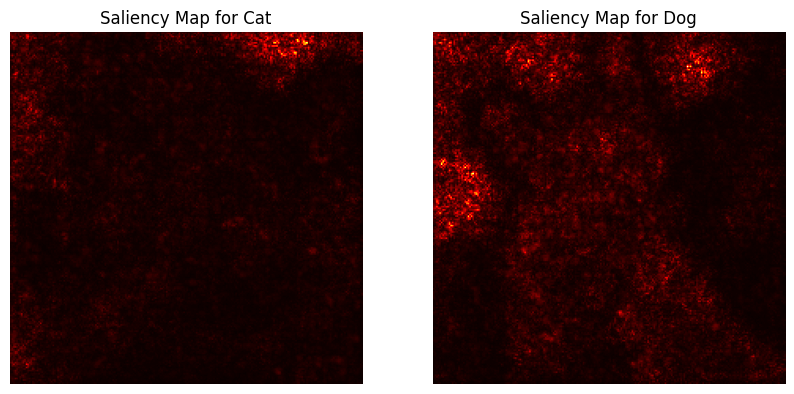

In [12]:
# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define a transform to resize and normalize the image as expected by ResNet50
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to create saliency map from an uploaded image
def create_saliency_map(image):
    img_t = transform(image)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t.requires_grad_()

    output = model(batch_t)
    _, pred_idx = torch.max(output, 1)
    pred_score = output[0, pred_idx]

    pred_score.backward()

    saliency, _ = torch.max(batch_t.grad.data.abs(), dim=1)
    return saliency[0]

# Upload two images (cat and dog)
print("Upload a cat image:")
uploaded_cat = files.upload()

print("Upload a dog image:")
uploaded_dog = files.upload()

# Open the uploaded cat image
for file_name in uploaded_cat.keys():
    image_cat = Image.open(io.BytesIO(uploaded_cat[file_name]))

# Open the uploaded dog image
for file_name in uploaded_dog.keys():
    image_dog = Image.open(io.BytesIO(uploaded_dog[file_name]))

# Generate saliency maps for both cat and dog images
saliency_cat = create_saliency_map(image_cat)
saliency_dog = create_saliency_map(image_dog)

# Plot the saliency maps for both images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Saliency map for cat
ax[0].imshow(saliency_cat, cmap='hot')
ax[0].axis('off')
ax[0].set_title("Saliency Map for Cat")

# Saliency map for dog
ax[1].imshow(saliency_dog, cmap='hot')
ax[1].axis('off')
ax[1].set_title("Saliency Map for Dog")

plt.show()


Mean and Standard Deviation of Saliency Map Intensities

In [13]:
import numpy as np
# Convert the saliency maps to numpy arrays for analysis
saliency_cat_np = saliency_cat.numpy()
saliency_dog_np = saliency_dog.numpy()

# Calculate mean and standard deviation for cat saliency map
cat_mean = np.mean(saliency_cat_np)
cat_std = np.std(saliency_cat_np)

# Calculate mean and standard deviation for dog saliency map
dog_mean = np.mean(saliency_dog_np)
dog_std = np.std(saliency_dog_np)

print(f"Cat Saliency Map - Mean: {cat_mean}, Std Dev: {cat_std}")
print(f"Dog Saliency Map - Mean: {dog_mean}, Std Dev: {dog_std}")


Cat Saliency Map - Mean: 0.012283655814826488, Std Dev: 0.015082404948771
Dog Saliency Map - Mean: 0.02142985910177231, Std Dev: 0.02390356920659542


Histogram of Saliency Map Intensities

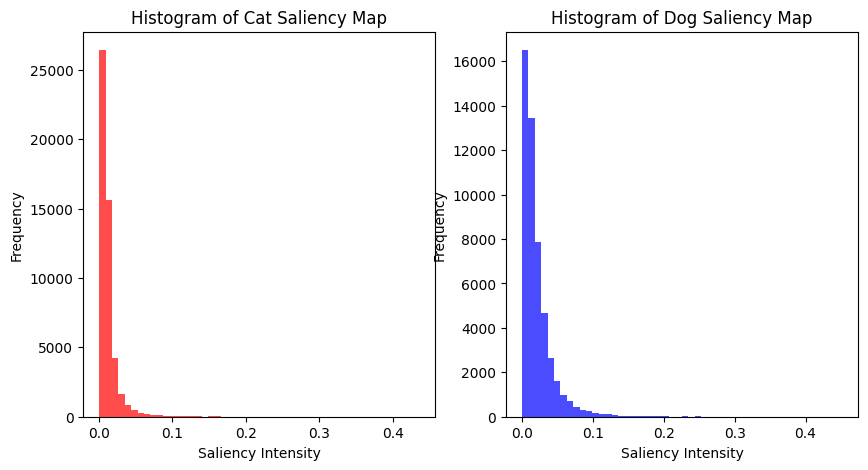

In [14]:
# Plot histograms for saliency maps
plt.figure(figsize=(10, 5))

# Histogram for cat saliency map
plt.subplot(1, 2, 1)
plt.hist(saliency_cat_np.flatten(), bins=50, color='red', alpha=0.7)
plt.title("Histogram of Cat Saliency Map")
plt.xlabel("Saliency Intensity")
plt.ylabel("Frequency")

# Histogram for dog saliency map
plt.subplot(1, 2, 2)
plt.hist(saliency_dog_np.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Dog Saliency Map")
plt.xlabel("Saliency Intensity")
plt.ylabel("Frequency")

plt.show()

Statistical Testing (T-test)

In [15]:
from scipy.stats import ttest_ind

# Perform a t-test on saliency map intensities
t_stat, p_value = ttest_ind(saliency_cat_np.flatten(), saliency_dog_np.flatten())

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -72.4851947453121, P-value: 0.0


# Visual Comparison:

*   Both the Cat and Dog saliency maps show that the model places the highest importance on specific regions in the images, but the distribution of saliency intensities differs between the two classes.

*   The histogram for the cat saliency map shows a sharp concentration of low-intensity values (close to 0), suggesting that the model is focusing on a few specific regions with less spread of importance.

*   The histogram for the dog saliency map is also concentrated at lower intensities but appears more spread out than the cat, indicating that the model’s attention is distributed over more regions in the dog image.


# Quantitative Analysis:


*   The mean saliency intensity for the cat image is 0.0123, while for the dog image, it is 0.0214. This indicates that, on average, the model assigns higher importance to regions in the dog image compared to the cat image.

*   The standard deviation for the cat saliency map is 0.0151, compared to 0.0239 for the dog saliency map, suggesting that the model's focus in the dog image is more dispersed, while in the cat image, it is more concentrated in specific areas.

# Statistical Testing (T-test):


*   The t-statistic is -72.49, and the p-value is 0.0 (extremely small), indicating a highly significant difference between the saliency intensities for the cat and dog images.
*   Since the p-value is less than 0.05, we reject the null hypothesis (H0) and conclude that there is a significant difference in the model’s feature importance between the "cat" and "dog" images.

# Conclusion

To put in a nutshell, The ResNet50 model does show a significant difference in how it focuses on different features in images of cats and dogs. The saliency map analysis indicates that the model assigns more dispersed importance across regions in dog images and concentrates more on specific regions in cat images. Therefore, we reject the null hypothesis and conclude that the model distinguishes these classes differently in terms of feature importance.